In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#

#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200
#plt.rcParams["font.family"] = "monospace"
 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(['science','notebook'])



#pylab.rc('xtick', labelsize=18) 
#pylab.rc('ytick', labelsize=18) 
#pylab.rc('axes', labelsize=16)
#pylab.rc('legend', fontsize=15)

### Specify locationof files below

In [2]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e**3 + A[6]*e*q + A[7]*(e**2)*q + A[8]*e*(q**2) + A[9]*(e**2)*(q**2) + A[10]*(e**3)*q + A[11]*e*q*math.cos(l + A[12]) + A[13]*(e**2)*(q**2)*math.cos(e*l + A[14]) + A[15]*(e**3)*q*math.cos(l + A[16]) + A[17]*e*(q**2)*math.cos(l + A[18])

g=open('tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e**3 + B[6]*e*eta + B[7]*(e**2)*eta + B[8]*e*(eta**2) + B[9]*(e**2)*(eta**2) + B[10]*(e**3)*eta + B[11]*e*eta*math.cos(l + B[12]) + B[13]*(e**2)*(eta**2)*math.cos(l + B[14]) + B[15]*(e**3)*eta*math.cos(e*l + B[16])

g=open('tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e**3 + C[6]*e*eta + C[7]*(e**2)*eta + C[8]*e*(eta**2) + C[9]*(e**2)*(eta**2) + C[10]*(e**3)*eta + C[11]*e*eta*math.cos(l + C[12]) + C[13]*(e**2)*(eta**2)*math.cos(l + C[14]) + C[15]*(e**3)*eta*math.cos(e*l + C[16])+ C[17]*(e**3)*(eta**2)*math.cos(e*l + C[18])

In [3]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


print(A)
print(B)
print(C)

In [4]:
print(fconv(0.075,65))

20.42110007630271


##   hybrid     $\;\;\;\;e_o$      $\;\;\;\;\ell_o$
###  1355       $\;\;\;\;\; 0.120$   $\;\;\;1.423\;\;$   training
###  1356       $\;\;\;\;\; 0.163$   $\;\;\;1.574$
###  1357       $\;\;\;\;\; 0.227$   $\;\;\;0.451\;\;$   training
###  1358       $\;\;\;\;\; 0.227$   $\;\;\;-2.682$
###  1359       $\;\;\;\;\; 0.227$   $\;\;\;1.834$
###  1360       $\;\;\;\;\; 0.299$   $\;\;\;-0.395$
###  1361       $\;\;\;\;\; 0.299$   $\;\;\;-1.019$
###  1362       $\;\;\;\;\; 0.373$   $\;\;\;-0.507\;\;$   training
###  1363       $\;\;\;\;\; 0.373$   $\;\;\;-0.912$
### q = 2
###  1364       $\;\;\;\;\; 0.120$   $\;\;\;-0.181\;\;$   training
###  1365       $\;\;\;\;\; 0.145$   $\;\;\;-1.127$
###  1366       $\;\;\;\;\; 0.228$   $\;\;\;-2.890$
###  1367       $\;\;\;\;\; 0.228$   $\;\;\;1.687$
###  1368       $\;\;\;\;\; 0.228$   $\;\;\;0.420\;\;$   training
###  1369       $\;\;\;\;\; 0.373$   $\;\;\;-0.203\;\;$   training
###  1370       $\;\;\;\;\; 0.373$   $\;\;\;3.063$
### q = 3
###  1371       $\;\;\;\;\; 0.142$   $\;\;\;0.665\;\;$   training
###  1372       $\;\;\;\;\; 0.209$   $\;\;\;3.005$
###  1373       $\;\;\;\;\; 0.209$   $\;\;\;1.682\;\;$   training
###  1374       $\;\;\;\;\; 0.359$   $\;\;\;3.114\;\;$   training

### call hybrids except 1360,1361,1370 using the current Hinder+inspired model

In [4]:
hfile = ['1371hyb_EccTD_xlow045_GM.h5']  #hybrids
l0 = 0.665
#xref = 0.075
x0 = 0.045
e0 = 0.142
q = 3
eta = q/(1+q)**2

f0 = 20

#ecc = []

In [5]:
print((PI*f0*200*MTSUN_SI)**(2/3))  #22mode

0.1564730678081897


In [6]:
for i in range(0,len(hfile)):
    hyb_name = hfile[i][0:4]
    f = h5py.File(hfile[i],'r')
    data = f['l2_m2']
    tVec = real(data[0:,0])
    h22pVec = real(data[0:,1])
    h22cVec = real(data[0:,2])
    mode2polfac=4*(5/(64*np.pi))**(1/2)
    hpVec=h22pVec
    hcVec=h22cVec

    tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]
    #print(Mtot[i])
    M=40
    M1 = q*M/(1+q)
    M2 = M/(1+q)
    q0 = q
    M_SI=M*MSUN_SI
    D_SI=(10**(6))*PC_SI
    tVec=tVec*M*MTSUN_SI
    hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    
    
    tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]

    delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))

    fref = 0.075**(3/2) /MTSUN_SI/ PI/M
    fmin = 0.045**(3/2) /MTSUN_SI/ PI/M
    #fmin=f0

    #momegai = 2*PI*f0*M*MTSUN_SI

    hp, hc = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, eccentricity=e0)
    sp, sc = get_td_waveform(approximant='SEOBNRv4', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin)

    tshift = - tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
    tmin = max(tVec[0],hp.sample_times[0]-tshift,sp.sample_times[0])# + 0.04
    #print(tmin/(M*MTSUN_SI))
    #alternate
    plotband = np.where(tVec>=tmin)[0][0]
    hpVec = hpVec[plotband:]
    hcVec = hcVec[plotband:]
    tVec = tVec[plotband:]


    h22Hyb = hpVec + 1j*hcVec
    tVec = tVec - tVec[np.argmax(abs(h22Hyb))]
    phaseHyb = -np.unwrap(np.angle(h22Hyb)*2)/2
    omegaHyb = (M*MTSUN_SI/delta_t)*(np.gradient(phaseHyb))
    #hstr = np.where(omegaHyb>=momegai)[0][0]

    #h22Hyb = h22Hyb[hstr:]


    #circular IMR
    sp_intrp = interp1d(sp.sample_times, sp, kind='cubic',fill_value='extrapolate')
    sc_intrp = interp1d(sc.sample_times, sc, kind='cubic',fill_value='extrapolate')
    tImr_intrp=np.arange(tmin, sp.sample_times[-1], delta_t)
    sp_intrp = sp_intrp(tImr_intrp)
    sc_intrp = sc_intrp(tImr_intrp)
    tImr = tImr_intrp
    hpImr = sp_intrp
    hcImr = sc_intrp
    h22Imr = hpImr + 1j*hcImr


    "time shift"
    "Hinder+ inspired"
    tshift = - tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI
    #print(- tshift_Hinsp(q0,e0,l0))

    # interpolation EccentricTD
    #hp_intrp = interp1d(hp.sample_times-tshift, hp, kind='cubic',fill_value='extrapolate')
    hp_intrp = interp1d(hp.sample_times-tshift, hp, kind='cubic',fill_value='extrapolate')
    hc_intrp = interp1d(hc.sample_times-tshift, hc, kind='cubic',fill_value='extrapolate')
    # new (unifrom) sampling rate (for interpolation and further processing)
    tEcc_intrp=np.arange(tmin, hp.sample_times[-1]-tshift, delta_t)
    hp_intrp = hp_intrp(tEcc_intrp)
    hc_intrp = hc_intrp(tEcc_intrp)
    tEcc = tEcc_intrp
    hpEcc = hp_intrp
    hcEcc = hc_intrp
    h22Ecc = hpEcc + 1j*hcEcc

    phaseEcc = np.unwrap(np.angle(h22Ecc)*2)/2
    phaseImr = np.unwrap(np.angle(h22Imr)*2)/2

    #######
    dphase = phaseEcc[0] - phaseImr[0]
    hp_new = real(h22Ecc * exp(-1j * dphase))
    hc_new = imag(h22Ecc * exp(-1j * dphase))

    phase_new = np.unwrap(np.angle(hp_new+1j*hc_new)*2)/2
    #print(phase_new[0])

    phaseEcc = phase_new
    h22Ecc_new = hp_new+1j*hc_new

    "Hinder+ inspired"
    arg = np.argmin(abs(tEcc - tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI))
    Idxjoin = arg #startIdx
    #print(tamp_Hinsp(eta,e0,l0))

    "Hinder+ inspired"
    t_amp = tamp_Hinsp(eta,e0,l0) - 500


    idxstr = np.argmin(abs(tEcc-t_amp*M*MTSUN_SI))
    #print(tEcc[idxstr]/(Mtot[i]*MTSUN_SI))
    "amplitude model"
    amp = []
    count = 0
    length = Idxjoin - idxstr 

    for i in range(idxstr,Idxjoin):
        amp.append(((length-count)*abs(h22Ecc_new[i])+count*abs(h22Imr[i]))/length)
        count = count+1

    t_model = np.concatenate((tEcc[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
    h22amp = np.concatenate((abs(h22Ecc_new[0:idxstr]),amp))
    h22amp_model = np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))

    omegaEcc = (M*MTSUN_SI/delta_t)*(np.gradient(phaseEcc))
    omegaImr = (M*MTSUN_SI/delta_t)*(np.gradient(phaseImr))

    "Hider+ inspired"
    tjoin0 = tfreq_Hinsp(eta,e0,l0)
    tjoin = tjoin0 * M * MTSUN_SI
    fjoin = np.argmin(abs(tEcc-tjoin)) #+ 500


    "frequency model"
    tstop = min(tEcc[-1],-30*M*MTSUN_SI)
    lst = np.argmin(abs(tEcc-tstop))

    #lst = len(tEcc)

    indx = lst - fjoin
    a0 = []
    n = indx - 1 
    k = 0
    for i in range(fjoin,fjoin+indx):   #fjoin - 500
        a0.append(((n-k)*omegaEcc[i]+k*omegaImr[i])/n)
        k = k+1

    f1 = np.concatenate((omegaEcc[0:fjoin],a0))
    frequency_model = np.concatenate((f1,omegaImr[fjoin+indx:len(omegaImr)]))
    phase_f_model = np.cumsum(frequency_model)/(M*MTSUN_SI/delta_t) + PI/1.4#PI/2.1#PI/0.1#


    hp_f_model = h22amp_model * np.cos(phase_f_model)

In [7]:
plt.rc('xtick', labelsize=18) #28
plt.rc('ytick', labelsize=18) #28
mpl.rcParams['xtick.major.size'] = 18
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 12
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 18
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 12
mpl.rcParams['ytick.minor.width'] = 1

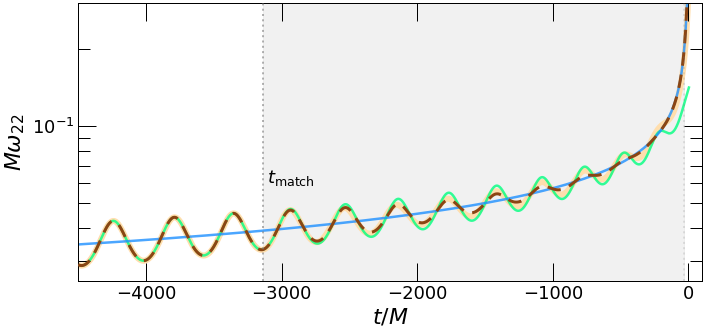

In [19]:
plt.figure(figsize=(10,4.8))
#plt.plot(tVec/(M*MTSUN_SI), omegaHyb,color='gold',linewidth=5,alpha = 0.9,label='hybrid',zorder=1)
#plt.plot(t_model/(M*MTSUN_SI), frequency_model, color='royalblue',alpha=1,linestyle='--',linewidth=3,label='model',zorder=3)
#plt.plot(tEcc/(M*MTSUN_SI),omegaEcc,linestyle='-',linewidth=2,color='red',alpha=0.8,label='EccentricTD',zorder=2)
#plt.plot(tImr/(M*MTSUN_SI),omegaImr,linestyle='-',linewidth=2,color='lawngreen',alpha=0.8,label='SEOBNRv4',zorder=2)

plt.plot(tVec/(M*MTSUN_SI), omegaHyb,color='navajowhite',linewidth=6,alpha = 1,label='hybrid',zorder=1)
plt.plot(t_model/(M*MTSUN_SI), frequency_model, color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=3,label='model',zorder=3)
plt.plot(tEcc/(M*MTSUN_SI),omegaEcc,linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
plt.plot(tImr/(M*MTSUN_SI),omegaImr,linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)



plt.xlim(xmin=-4500)
plt.xlim(xmax=100)
plt.ylim(ymin=2.5e-2)
plt.ylim(ymax=3e-1)
plt.axvline(x=tjoin/(M*MTSUN_SI),color='grey',linestyle=':',zorder=5,alpha=0.6)
plt.axvline(x=tstop/(M*MTSUN_SI),color='grey',linestyle=':',zorder=5,alpha=0.2)
plt.axvspan(tjoin/(M*MTSUN_SI),tstop/(M*MTSUN_SI),color='lightgrey',alpha=0.3)
#plt.legend(loc=2,ncol=1,fontsize=9)
#leg = plt.legend(ncol=1,loc=2,bbox_to_anchor=(0.01,0.98),prop={'size': 20})
#leg._legend_box.align = "center"
plt.ylabel(r'$M \omega_{22}$',fontsize=22,labelpad=5)
plt.xlabel(r'$t/M$',fontsize=22)
plt.text(-3110,6e-2,r'$t_{\rm{match}}$',fontsize=18)
plt.yscale('log')
#plt.minorticks_off()
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tight_layout()
#plt.savefig('frequency_model_1371.pdf')

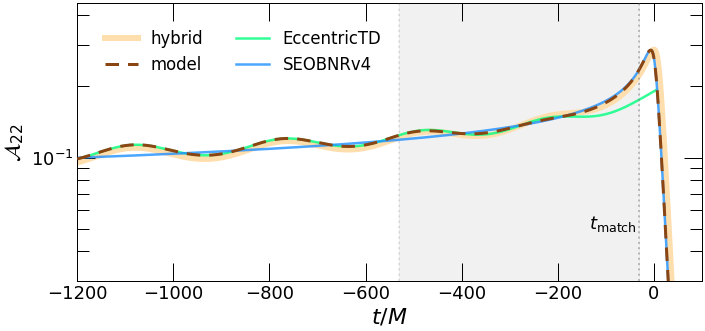

In [21]:
#plt.figure(figsize=(12,5))
plt.figure(figsize=(10,4.8))
#plt.plot(tVec/(M*MTSUN_SI), abs(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='gold',linewidth=5,alpha = 0.9,label='hybrid',zorder=1)
#plt.plot(t_model/(M*MTSUN_SI), h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='royalblue',alpha=1,linestyle='--',linewidth=3,label='model',zorder=3)
#plt.plot(tEcc/(M*MTSUN_SI),abs(h22Ecc_new)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2,color='red',alpha=0.8,label='EccentricTD',zorder=2)
#plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2,color='lawngreen',alpha=0.8,label='SEOBNRv4',zorder=2)

plt.plot(tVec/(M*MTSUN_SI), abs(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=6,alpha = 1,label='hybrid',zorder=1)
plt.plot(t_model/(M*MTSUN_SI), h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=3,label='model',zorder=3)
plt.plot(tEcc/(M*MTSUN_SI),abs(h22Ecc_new)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)


plt.xlim(xmin=-1200)
plt.xlim(xmax=100)
plt.ylim(ymax=4.5e-1)
plt.ylim(ymin=3e-2)
plt.yscale('log')
plt.axvline(x=t_amp,color='grey',linestyle=':',zorder=5,alpha=0.2)
plt.axvline(x=(t_amp+500),color='grey',linestyle=':',zorder=5,alpha=0.5)
plt.axvspan(t_amp,(t_amp+500),color='lightgrey',alpha=0.3)
leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 16.5})
leg._legend_box.align = "center"
plt.ylabel(r'$\mathcal{A}_{22}$',fontsize=22,labelpad=5)
plt.xlabel(r'$t/M$',fontsize=22)
plt.text(-135,0.05,r'$t_{\rm{match}}$',fontsize=18)
#plt.minorticks_off()
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tight_layout()
#plt.yscale('log')
#plt.savefig('amplitude_model_1371.pdf')

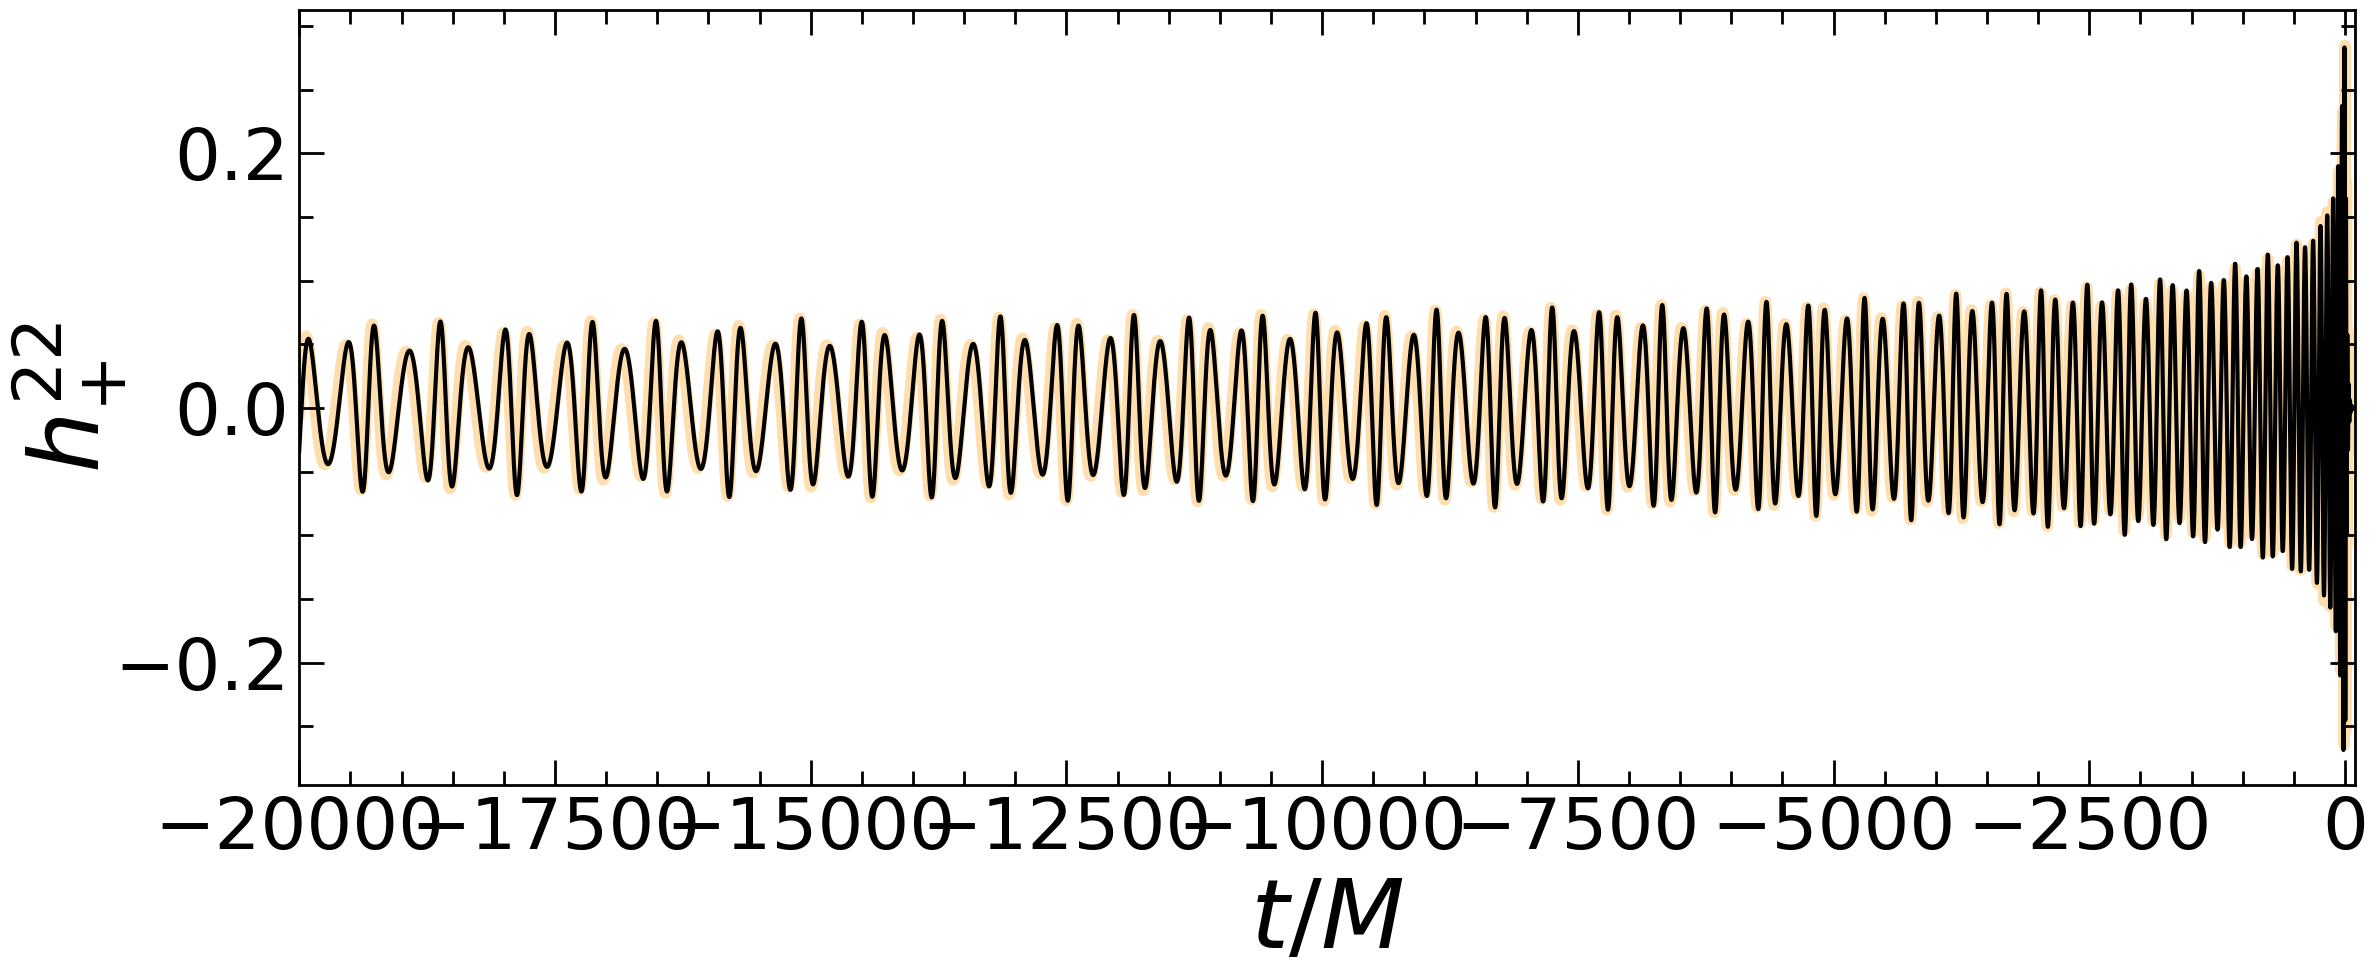

In [176]:
plt.figure(figsize=(12,5))
plt.plot(tVec/(M*MTSUN_SI), real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=4,alpha = 1,label='hybrid',zorder=1)
plt.plot(t_model/(M*MTSUN_SI), hp_f_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='black',alpha=1,linestyle='-',linewidth=1.5,label='model',zorder=3)
#plt.plot(tEcc/(M*MTSUN_SI),abs(h22Ecc_new)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2,color='red',alpha=0.8,label='EccentricTD',zorder=2)
#plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2,color='lawngreen',alpha=0.8,label='SEOBNRv4',zorder=2)
plt.xlim(xmin=-20000)
plt.xlim(xmax=100)
#plt.ylim(ymax=4.1e-1)
#plt.ylim(ymin=3e-2)
#plt.yscale('log')
#plt.axvline(x=t_amp,color='grey',linestyle=':',zorder=5,alpha=0.2)
#plt.axvline(x=(t_amp+500),color='grey',linestyle=':',zorder=5,alpha=0.5)
#plt.axvspan(t_amp,(t_amp+500),color='lightgrey',alpha=0.3)
#plt.legend(loc=2,ncol=1,fontsize=9)
#leg = plt.legend(ncol=1,loc=2,bbox_to_anchor=(0.01,0.98),prop={'size': 20})
#leg._legend_box.align = "center"
plt.ylabel(r'$h_{+}^{22}$',fontsize=35,labelpad=-5)
plt.xlabel(r'$t/M$',fontsize=35)
#plt.text(-115,0.05,r'$t_{match}$',fontsize=25)
plt.tight_layout()
#plt.yscale('log')
#plt.savefig('amplitude_model_1371.pdf')

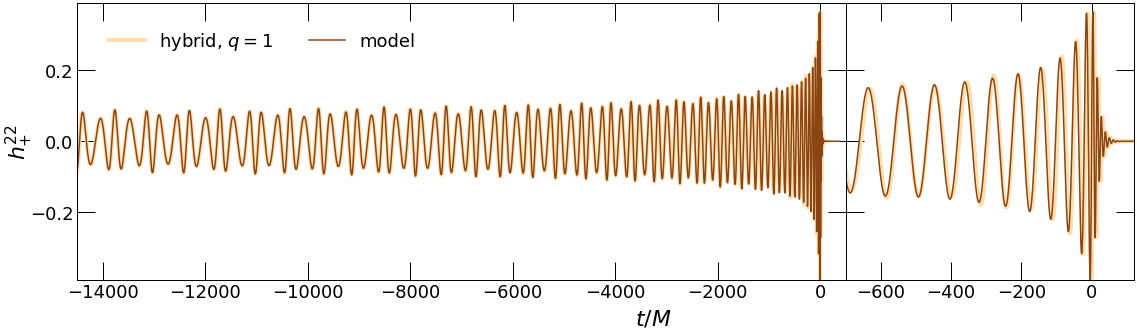

In [43]:
#fig = plt.figure(figsize=(20,5)) 
fig = plt.figure(figsize=(16,4.8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 3]) 
gs.update(wspace=0.0)
ax0 = plt.subplot(gs[0])
ax0.plot(tVec/(M*MTSUN_SI), real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=4,label=r'hybrid, $q = %d$'%q)
ax0.plot(t_model/(M*MTSUN_SI), hp_f_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',linestyle='-',linewidth=1.5,label='model')
ax0.set_xlim([-14500,500])
ax0.set_ylim([-0.39,0.39])
ax0.set_ylabel(r'$h_{+}^{22}$',fontsize=22,labelpad=-5)
ax0.set_xlabel(r'$t/M$',fontsize=22,labelpad=10)
ax0.xaxis.set_label_coords(0.75, -0.1)
plt.minorticks_off()
leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 18})
leg._legend_box.align = "center"

ax1 = plt.subplot(gs[1],sharey=ax0)
ax1.plot(tVec/(M*MTSUN_SI), real(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=4,label='hybrid')
ax1.plot(t_model/(M*MTSUN_SI), hp_f_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',linestyle='-',linewidth=1.5,label='model')
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.set_xlim([-700,120])
plt.tight_layout()
plt.minorticks_off()
#plt.savefig('h_plus_1371_test.pdf')

In [44]:
globals()['NR' + str(hfile[0][0:4])] = abs(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
globals()['omega' + str(hfile[0][0:4])] = omegaHyb
globals()['tNR' + str(hfile[0][0:4])] = tVec/(M*MTSUN_SI)

globals()['m' + str(hfile[0][0:4])] = h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
globals()['momega' + str(hfile[0][0:4])] = frequency_model
globals()['tm' + str(hfile[0][0:4])] = t_model/(M*MTSUN_SI)

print('tNR'+str(hfile[0:4]))
print(hfile[0][0:4])

plt.plot(tNR1357,NR1357)

pylab.rc('axes', labelsize=35)
pylab.rc('legend', fontsize=22)
plt.rc('xtick', labelsize=28) 
plt.rc('ytick', labelsize=28) 
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 1

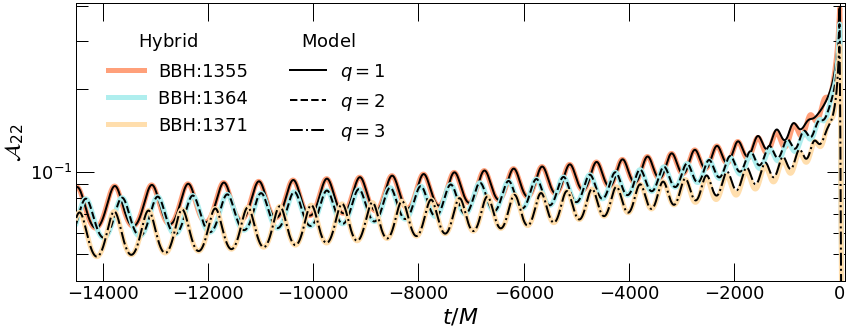

In [49]:
#plt.figure(figsize=(15,6))
plt.figure(figsize=(12,4.8))
#plt.plot([],[],color='white',label=r'Hybrid Model')
plt.plot(tNR1355,NR1355,color='lightsalmon',linewidth=5.0,label=r'BBH:1355',zorder=0)
plt.plot(tNR1364,NR1364,color='paleturquoise',linewidth=5.0,label=r'BBH:1364 ',zorder=2)
plt.plot(tNR1371,NR1371,color='navajowhite',linewidth=5.0,label=r'BBH:1371',zorder=4)


#plt.plot([],[],color='white',label=' ')
plt.plot(tm1355,m1355,color='k',linewidth=2,linestyle='-',label = r'$q=1$',zorder=1)
plt.plot(tm1364,m1364,color='k',linewidth=2,linestyle='--',label = r'$q=2$',zorder=3)
plt.plot(tm1371,m1371,color='k',linewidth=2,linestyle='-.',label = r'$q=3$',zorder=5)

plt.plot()
plt.ylim(ymax=4.1e-1)
plt.ylim(ymin=4e-2)
plt.yscale('log')
plt.xlim(xmin=-14500)
plt.xlim(xmax=100)
#plt.title("PN-NR",fontsize=18)
plt.ylabel(r"$\mathcal{A}_{22}$", fontsize=22)
plt.xlabel(r"$t/M$", fontsize=22)
#plt.legend(ncol=2,title = r"Hybrid  Model",title_fontsize=15)

leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),title = r"Hybrid $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Model",title_fontsize=18,prop={'size': 18})
leg._legend_box.align = "center"
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tight_layout()
#plt.savefig('amp_model.pdf')
#plt.savefig('amp_model_delta_t.pdf')

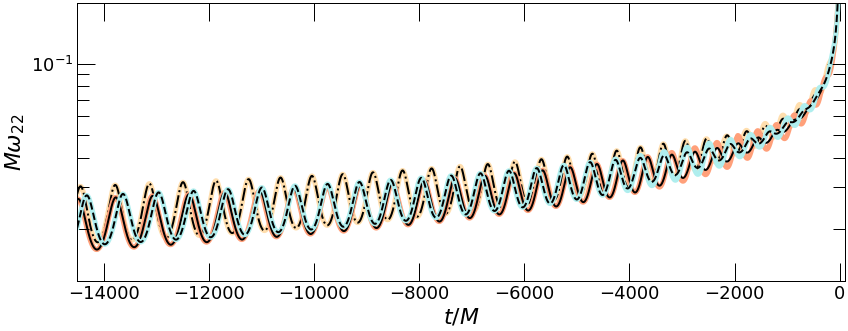

In [48]:
plt.figure(figsize=(12,4.8))
#plt.plot([],[],color='white',label=r'Hybrid Model')
plt.plot(tNR1355,omega1355,color='lightsalmon',linewidth=5,label=r'BBH:1355',zorder=0)
plt.plot(tNR1364,omega1364,color='paleturquoise',linewidth=5,label=r'BBH:1364',zorder=2)
plt.plot(tNR1371,omega1371,color='navajowhite',linewidth=5,label=r'BBH:1371',zorder=-4)


#plt.plot([],[],color='white',label=' ')
plt.plot(tm1355,momega1355,color='black',linewidth=2,linestyle='-',label = r'$q=1$',zorder=1)
plt.plot(tm1364,momega1364,color='black',linewidth=2,linestyle='--',label = r'$q=2$',zorder=3)
plt.plot(tm1371,momega1371,color='black',linewidth=2,linestyle='-.',label = r'$q=3$',zorder=-3)


plt.ylim(ymax=1.8e-1)
plt.ylim(ymin=1.2e-2)
plt.yscale('log')
plt.xlim(xmin=-14500)
plt.xlim(xmax=100)
#plt.title("PN-NR",fontsize=18)
plt.ylabel(r"$M\omega_{22}$", fontsize=22)
plt.xlabel(r"$t/M$", fontsize=22)

#leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.01,0.98),title = r"Hybrid $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Model",title_fontsize=25#,prop={'size': 25#})
#leg._legend_box.align = "center"
plt.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.tight_layout()
#plt.savefig('omega_model.pdf')
#plt.savefig('omega_model_delta_t.pdf')
